In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
from ipywidgets import IntProgress
from IPython.display import display
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import pickle
from prettytable import PrettyTable

from codes.Q_BAI import Q_SAR, uniform_sampling, Q_UGapEb, Q_SAR_Simplified, batch_elimination
from codes.Mean_BAI import UGapEb, SAR_Simplified
from codes.Environment import Mixture_AbsGau, setup_env, Exp
from codes.SimulatedGames import simulate, simulate_mean
from codes.plots import plot_hist, plot_eva, plot_eva_m

%matplotlib inline

In [2]:
# environment

environments = [
    {Mixture_AbsGau: [[0, 1.5, 0,1, 1], [3.5, 2, 0, 1, 1], 
                      [0, 1.5, 0,1, 1], [3.5, 2, 0, 1, 1], 
                      [0, 1.5, 0,1, 1], [3.5, 2, 0, 1, 1], 
                      [0, 1.5, 0,1, 1], 
                      [0, 1.5, 0,1, 1],  
                      [0, 1.5, 0,1, 1], 
                      [0, 1.5, 0,1, 1], 
                      [0, 1.5, 0,1, 1], 
                      [0, 1.5, 0,1, 1], 
                      [0, 1.5, 0,1, 1],
                      [0, 1.5, 0,1, 1], 
                      [0, 1.5, 0,1, 1], 
                      [0, 1.5, 0,1, 1], 
                      [0, 1.5, 0,1, 1], 
                      [0, 1.5, 0,1, 1],
                     ],
     Exp: [[1/4], [1/4]
          ]
    } # mu1, sigma1, mu2, sigma2, p
    
]


tau = 0.8 # quantile level
rewards_env, quantiles, Ls, means, samples = setup_env(environments, tau)

{<class 'codes.Environment.Mixture_AbsGau'>: [[0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1]], <class 'codes.Environment.Exp'>: [[0.25], [0.25]]}


In [3]:
# run experiments

def run_exper(rewards_env, summary_stats, policy, epsilon, m, budget_or_confi, num_exper, hyperpara_list, 
              fixed_samples_list = None, est_H_flag = False, est_L_flag = None, fixed_L = None , tau = None):
    for key in rewards_env.keys():
        for hyperpara in hyperpara_list:
            name = key + '_' + str(num_exper) + '_' + str(budget_or_confi) 
            policy_name = str(policy).split('.')[-1].split('\'')[0] + '-'
            subname = policy_name + str(hyperpara) 
            if est_H_flag:
                subname = 'Adp_' + subname
            print(name + subname)
            p = IntProgress(max = num_exper)
            p.description = 'Running'
            display(p)
            results[name][subname] = []
            est_Hs[name][subname] = []
            if est_H_flag:
                result, est_H_list = simulate(rewards_env[key],summary_stats[key], policy, 
                        epsilon, m, budget_or_confi, num_exper, hyperpara, p, fixed_samples_list,
                        est_H_flag, est_L_flag, fixed_L, tau)
                est_Hs[name][subname].append(est_H_list)
            else:
                result = simulate(rewards_env[key],summary_stats[key], policy, 
                        epsilon, m, budget_or_confi, num_exper, hyperpara, p, fixed_samples_list,
                        est_H_flag, est_L_flag, fixed_L, tau)
            results[name][subname].append(result)

In [4]:
# setting

results = defaultdict(dict)
est_Hs = defaultdict(dict)

num_arms = 20
num_exper = 100
budget = 3000
epsilon = 0
m = 2

est_L_flag = True # True: estimate the lower bound of hazard rate L; False: use the true L

In [5]:
run_exper(rewards_env, quantiles, Q_UGapEb, epsilon, m, budget, num_exper, [[200,1]], 
            est_H_flag = False, est_L_flag = est_L_flag, tau = tau)

run_exper(rewards_env, quantiles, Q_UGapEb, epsilon, m, budget, num_exper, [[8000,1]], 
            est_H_flag = True, est_L_flag = est_L_flag, tau = tau)

run_exper(rewards_env, quantiles, Q_SAR_Simplified, epsilon, m, budget, num_exper, [[1]], tau = tau)

# baseline algorithms

run_exper(rewards_env, quantiles, UGapEb, epsilon, m, budget, num_exper, [[200,1]], est_H_flag = False)

run_exper(rewards_env, quantiles, UGapEb, epsilon, m, budget, num_exper, [[150,1]], est_H_flag = True)

run_exper(rewards_env, quantiles, SAR_Simplified, epsilon, m, budget, num_exper, [[1]])

Mixture_AbsGau_[[0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1]]Exp_[[0.25], [0.25]]_100_4000Q_UGapEb-[200, 1]


IntProgress(value=0, description='Running')

Mixture_AbsGau_[[0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1]]Exp_[[0.25], [0.25]]_100_4000Adp_Q_UGapEb-[8000, 1]


IntProgress(value=0, description='Running')

Mixture_AbsGau_[[0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1]]Exp_[[0.25], [0.25]]_100_4000Q_SAR_Simplified-[1]


IntProgress(value=0, description='Running')

Mixture_AbsGau_[[0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1]]Exp_[[0.25], [0.25]]_100_4000UGapEb-[200, 1]


IntProgress(value=0, description='Running')

Mixture_AbsGau_[[0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1]]Exp_[[0.25], [0.25]]_100_4000Adp_UGapEb-[150, 1]


IntProgress(value=0, description='Running')

Mixture_AbsGau_[[0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [3.5, 2, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1], [0, 1.5, 0, 1, 1]]Exp_[[0.25], [0.25]]_100_4000SAR_Simplified-[1]


IntProgress(value=0, description='Running')

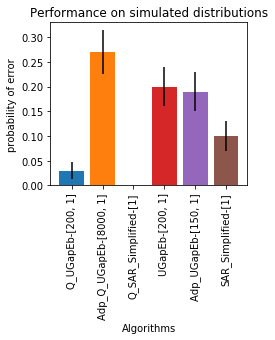

In [6]:
plot_eva(results, 'pe', paper_flag = False, save_flag = False)

In [7]:
#with open('Fixed_budget_20arms_new_env_group_two_est_gap.pickle', 'wb') as handle:
#    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
#with open('Fixed_budget_20arms_new_env_group_two_est_gap.pickle', 'rb') as handle:
#     results_others = pickle.load(handle)

In [8]:
#for key, value in results.items():
#    for key1, value1 in results[key].items():
#        results_others[key][key1] = value1